# Objectives

1. Sampling Bias
    - A. Full
    - B. Russia "Knockout"
    - C. Germany "Knockout"
1. Geocoding Bias
1. Drawing Bias

---
# Setup

## Modules

In [176]:
import os
import dill
import copy
import math

from Bio import Phylo
import pandas as pd
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib import lines

## Variables

In [81]:
from config import *

# Custom script variables
SCRIPT_NAME = "geo_bias"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

## File Paths

In [82]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")

outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
#tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
#tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_path    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_timetree.nwk")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

#print("tree_dill:\t", tree_dill)
#print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "geo_bias"

aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/geo_bias/all/chromosome_filter5


## Import Tree

In [129]:
# with open(tree_dill, "rb") as infile:
#     tt = dill.load(infile)
# tt.tree.ladderize(reverse=False)

tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [84]:
# with open(tree_df_dill, "rb") as infile:
#     tree_df = dill.load(infile)
# display(tree_df)

tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Import Colors

In [93]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)

# Add sizes
colors_df["Size"] = [NO_DATA_CHAR for i in range(0,len(colors_df))]
i = 0
for attr in list(dict.fromkeys(colors_df["Attribute"])):
    title_attr = attr.replace("_"," ").title().replace(" ","_")
    attr_df =  colors_df[colors_df["Attribute"] == attr]
    for state in attr_df["State"]:
        if attr == "branch_number":
            state = int(state)
        matches = tree_df[tree_df[title_attr] == state]
        colors_df.at[i,"Size"] = len(matches)
        i += 1

display(colors_df)
    
# Convert to dict
colors_dict = {}
sizes_dict = {}
for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    size = rec[1]["Size"]

    if attr not in colors_dict:
        colors_dict[attr] = {}
    if attr not in sizes_dict:
        sizes_dict[attr] = {}        
    colors_dict[attr][state] = color        
    sizes_dict[attr][state] = size

,Attribute,State,Color,Size
0,branch_number,0,#8000ff,210
1,branch_number,3,#00b4ec,12
2,branch_number,4,#80ffb4,15
3,branch_number,2,#ffb462,173
4,branch_number,1,#ff0000,206
...,...,...,...,...
202,province,Midlands,#ff1c0e,1
203,province,State of Mato Grosso,#ff150b,1
204,province,MSila,#ff0e07,1
205,province,La Paz,#ff0704,1


---
# Experiment Prep

- 3 Sources of bias to test:
  1. Sampling
    - geo_filter (All, Region1, Region2, ...)
  1. Geocoding
    - geo_attr (Country, Province)
  1. Connection
    - arrow_style (great circle, arc, straight)
  

In [94]:
# Global Variables
marker_scale = 2
marker_size = 20
branch = "1.PRE"
basemap = cimgt.Stamen('terrain-background')

arbitrary_arc = "arc3,rad=-0.3"
great_circle = "great_circle"

# Experiment Dataframe
columns = ["bias", "geo_attr", "geo_filter_attr", "geo_keep", "geo_remove", "arrow_style"]
experiments = [
    #["Sampling",   "Province", "Country", "All", None,      great_circle],
    #["Sampling",   "Province", "Country", "All", "Russia",  arbitrary_arc],
    #["Sampling",   "Province", "Country", "All", "Germany", arbitrary_arc],   
    ["Geocoding",  "Country",  "Country", "All", None,      great_circle],  
    ["Geocoding",  "Province", "Country", "All", None,      great_circle],
    #["Connection", "Province", "Country", "All", None,      great_circle], 
    #["Connection", "Province", "Country", "All", None,      curved_arrow],     
]

experiment_df = pd.DataFrame()
experiment_df = experiment_df.append(experiments)
experiment_df.columns = columns
display(experiment_df)

,bias,geo_attr,geo_filter_attr,geo_keep,geo_remove,arrow_style
0,Geocoding,Country,Country,All,None,great_circle
1,Geocoding,Province,Country,All,None,great_circle


### Create the subtree and sub dataframe

In [131]:
clade_df = tree_df[tree_df["Mugration_Branch_Major"] == branch]
clade = tree.common_ancestor(clade_df.index)
parent_node = copy.deepcopy(get_parent(tree, clade.root.name))
parent_rec = tree_df[tree_df.index.str.contains(parent_node.name)]
clade = parent_node
clade_df = clade_df.append(parent_rec)

# Prune clades outside
prune_nodes = []

for c in clade.find_clades(order="postorder"):
    if c.name not in clade_df.index:
        prune_nodes.append(c)

for node in prune_nodes:
    if node in clade.find_clades(node):
        try:
            clade.prune(node)
        except AttributeError as e:
            print(e)
            continue

can't set attribute


### Plot Subtree

[]

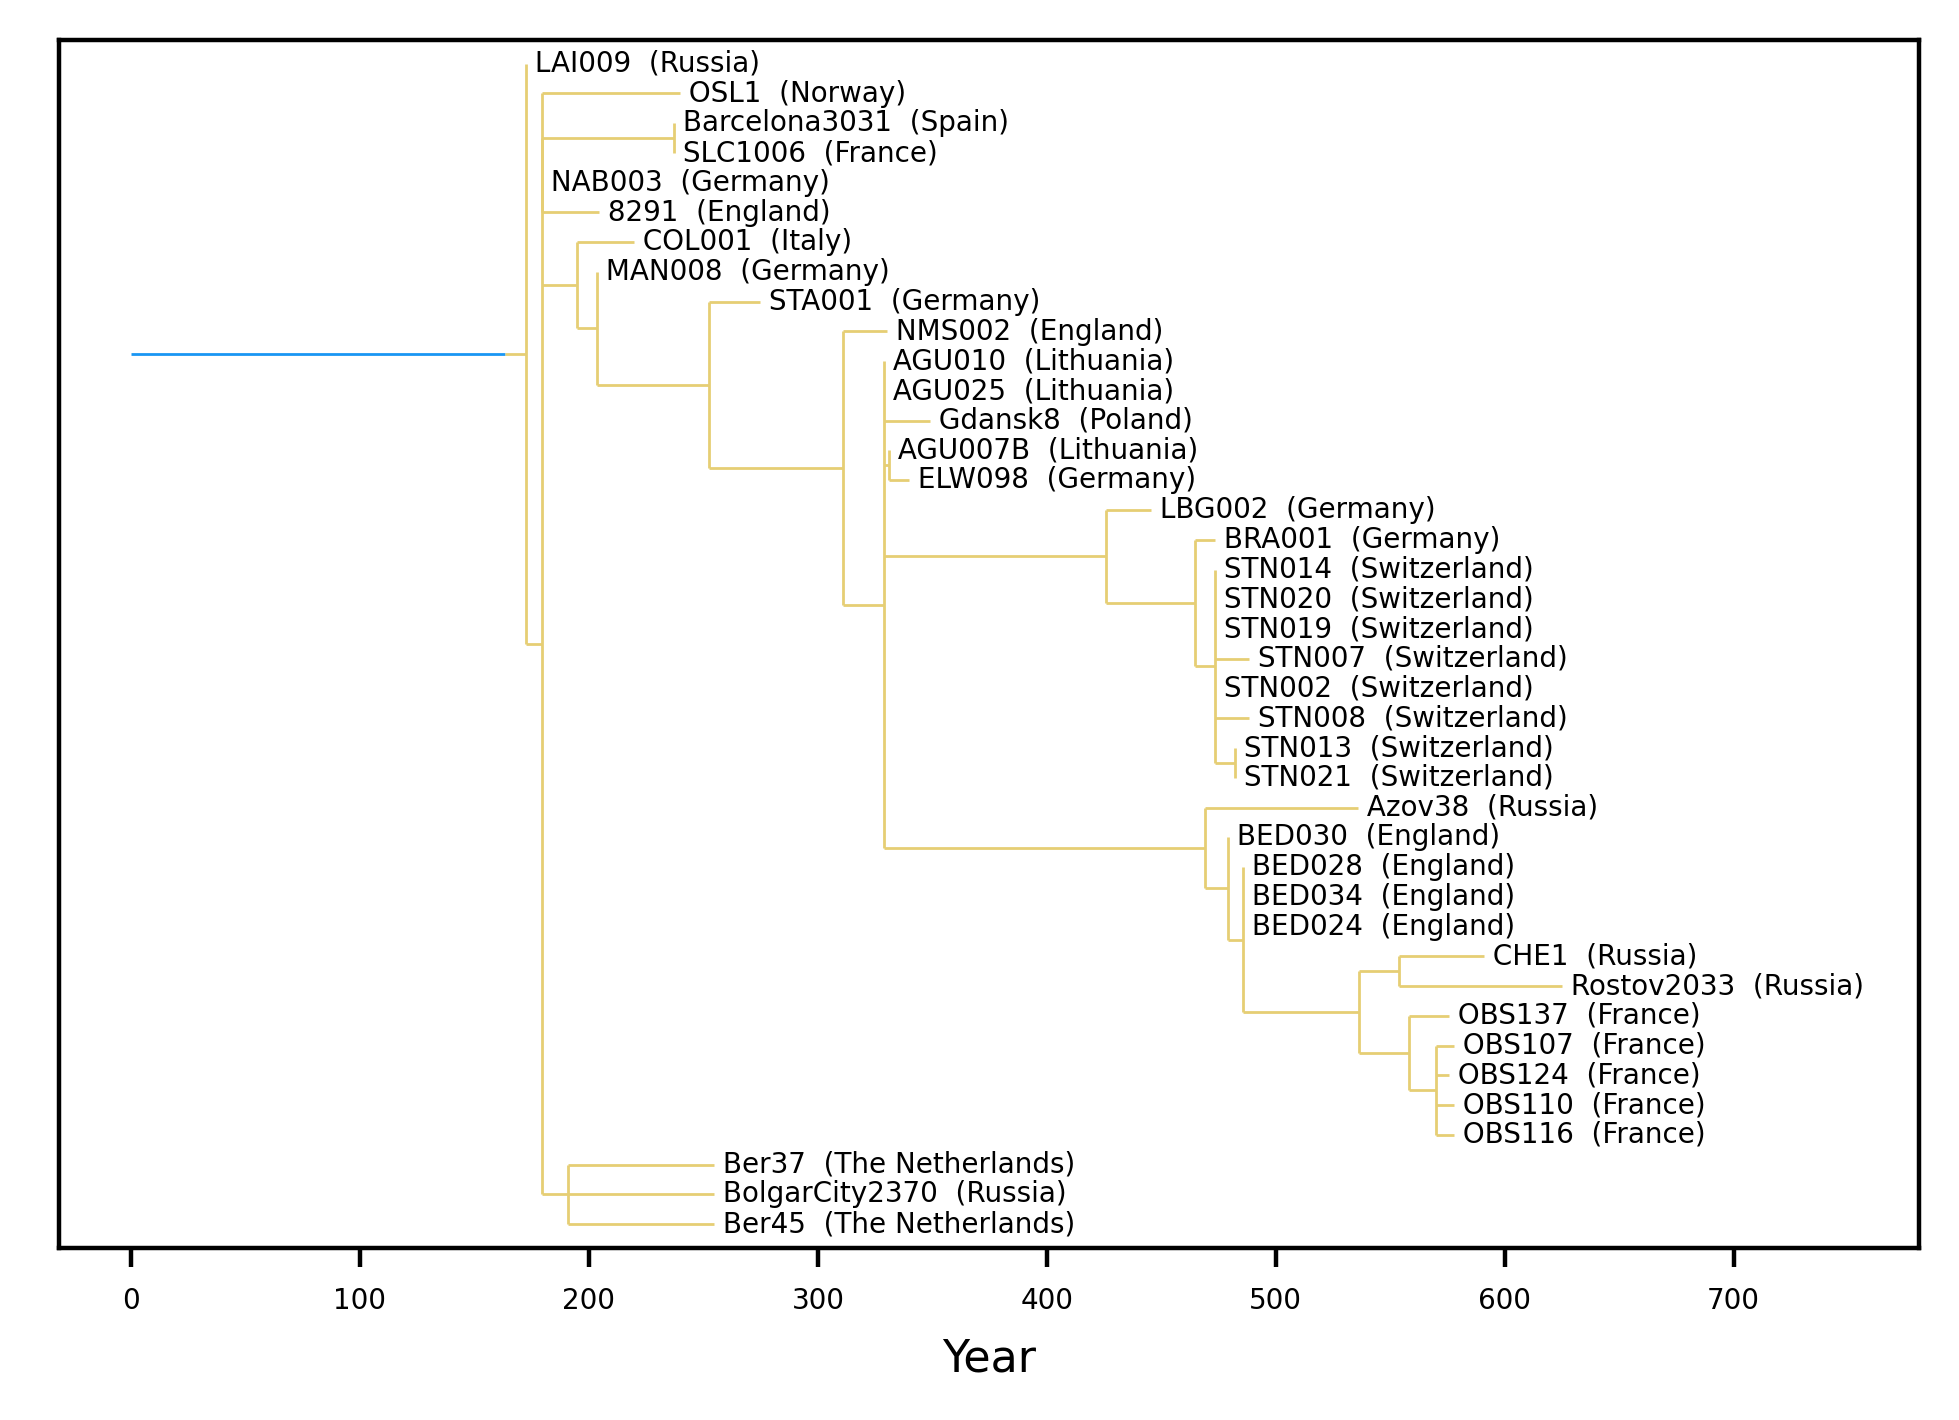

In [132]:
fig_tree, ax_tree = plt.subplots(1, dpi=dpi)

#plt.rc("lines", linewidth=1)

# Color tree
for c in clade.find_clades():
    state = tree_df["Mugration_Branch_Major"][c.name]
    color = colors_dict["branch_major"][state]
    c.color = color


Phylo.draw(clade,
             axes=ax_tree,
             show_confidence=False, 
             label_func = (lambda x: "{} ({})".format(
                     clade_df["Strain"][x.name] + " ", 
                     clade_df["Country"][x.name]) 
                 if x.is_terminal() else ''),
             #label_func = lambda x: '',
             do_show=False,
            )

ax_tree.set_title("")
ax_tree.set_xlabel("Year")
ax_tree.set_ylabel("")
ax_tree.set_yticks([])

---
# Run Experiments

## 2. Geocoding Bias

Line2D(_line0)
Line2D(_line1)
Line2D(_line2)
Line2D(_line3)
Line2D(_line4)
Line2D(_line5)
Line2D(_line6)
Line2D(_line7)
Line2D(_line8)
Line2D(_line9)
Line2D(_line10)
Line2D(_line11)
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()
Line2D()


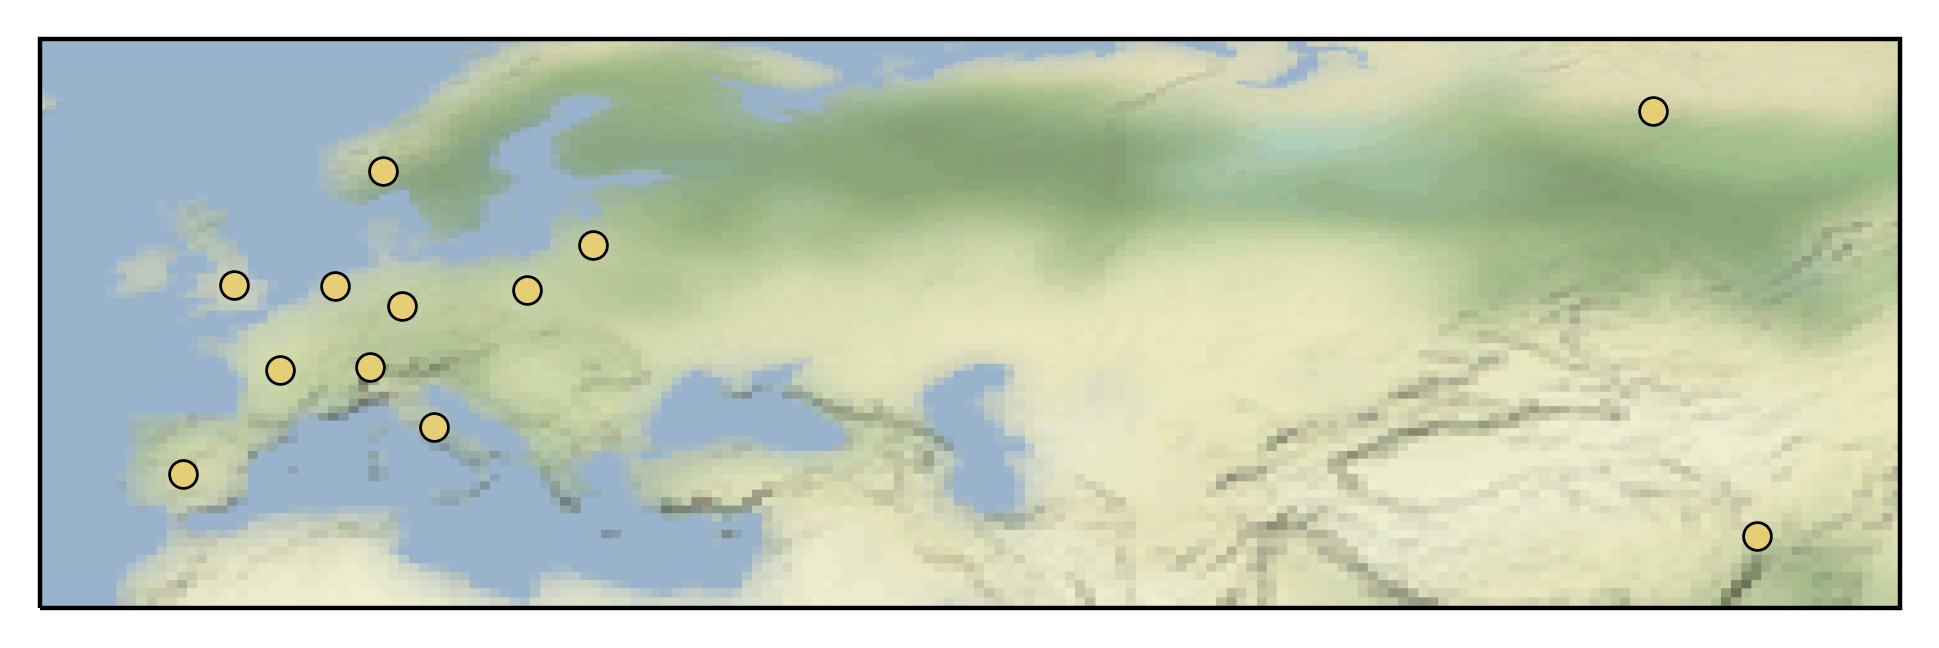

In [260]:
bias_df = experiment_df[experiment_df["bias"] == "Geocoding"]
for experiment in bias_df.iterrows():    
    
    # Get experiment-specific variables
    exp_tree = copy.deepcopy(clade)
    exp_parent_tree = get_parent(tree, exp_tree.root.name)
    geo_attr = experiment[1]["geo_attr"]
    geo_filter_attr = experiment[1]["geo_filter_attr"]
    geo_remove = experiment[1]["geo_remove"]
    arrow_style = experiment[1]["arrow_style"]
    exp_df = copy.deepcopy(clade_df)
    
    # Convert dataframe to geopandas
    exp_df = copy.deepcopy(clade_df)
    geometry = []
    for rec in exp_df.iterrows():
        sample = rec[0]
        x = exp_df["Mugration_" + geo_attr + "_Lon"][sample] 
        y = exp_df["Mugration_" + geo_attr + "_Lat"][sample]
        geometry.append(shapely.geometry.Point(x,y))

    exp_gdf = geopandas.GeoDataFrame(exp_df, crs=CRS, geometry=geometry)    
    
        
    # Prune/filter nodes
    for c in exp_tree.get_terminals():
        c_geo = tree_df["Mugration_" + geo_filter_attr][c.name]
        if c_geo == geo_remove:
            exp_tree.prune(c)   
            
    # Analyze connections
    connection_list = []
    node_connection_list = []

    for t in exp_tree.get_terminals():
        path = [exp_tree.root] + exp_tree.get_path(t)        
        for i in range(0, len(path) -1):
            origin_node = path[i].name
            origin_geom = exp_gdf["geometry"][origin_node]
            dest_node = path[i+1].name
            dest_geom = exp_gdf["geometry"][dest_node]
            dest_state = exp_df["Mugration_Branch_Major"][dest_node]
            dest_color = colors_dict["branch_major"][dest_state] 

            connection = lines.Line2D(
                [origin_geom.x, dest_geom.x], 
                [dest_geom.x, dest_geom.y],                                  
            )     
            if (origin_geom, dest_geom) not in connection_list:
                connection_list.append((origin_geom, dest_geom))         
                node_connection_list.append(connection) 

    # Setup Plot
    fig = plt.figure(dpi=dpi)  
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())   
    
    # Plot Nodes
    point_list = []
    node_marker_list = []
    for rec in exp_gdf.iterrows():
        name = rec[0]
        geometry = rec[1]["geometry"]
        state = exp_df["Mugration_Branch_Major"][name]
        color = colors_dict["branch_major"][state] 
        geo = exp_df[geo_attr.title()][name]
        marker = lines.Line2D([geometry.x], 
                              [geometry.y], 
                              marker="o",
                              markerfacecolor=color, 
                              markeredgecolor="black", 
                              markeredgewidth=0.5,
                              markersize=5, 
                             )

        if geometry not in point_list:
            point_list.append(geometry)
            node_marker_list.append(marker)
        
    
    # Plot Nodes
    [ax1.add_line(marker) for marker in node_marker_list]
    [print(marker) for marker in node_marker_list]
         
    # Plot Connection
    #[ax1.add_line(connection) for connection in node_connection_list] 
    [print(connection) for connection in node_connection_list]
    
    # Get Map Limits
    mb = Polygon(exp_gdf['geometry']).bounds
    xb = 10
    yb = 5
    map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
    ax1.set_extent(map_bounds, crs=ccrs.PlateCarree())   
    
    # Add basemap
    ax1.add_image(basemap, 1)
    break
             

---
# 2. Objective 2

---
# Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")